In [48]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.measure import label, regionprops
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import datasets
import json
import numpy as np
from utils import *
from matplotlib import pyplot as plt
from roboflow import Roboflow
from segment_anything import SamPredictor, sam_model_registry
from helper_code.pipeline import run_pipeline
import os
import random
from helper_code.full_extraction_pipeline import get_fast_bounding_box
import cv2

In [49]:
sam = sam_model_registry["default"](checkpoint="../../../Downloads/sam_vit_h_4b8939.pth")
sam_predictor = SamPredictor(sam)

In [50]:
rf = Roboflow(ROBOFLOW_API_KEY)
project = rf.workspace().project("final_annotation_classification")
model = project.version(1).model

loading Roboflow workspace...
loading Roboflow project...


In [57]:
image_num = 19764

Text(0.5, 1.0, 'Bounding Box in Image 19764')

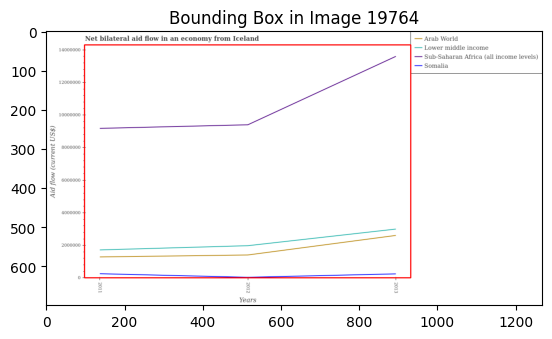

In [58]:
image_name, boundingBox = get_fast_bounding_box(image_num, sam_predictor)

image = cv2.imread(image_name)
cv2.rectangle(image, boundingBox['topLeft'], boundingBox['bottomRight'], (0, 0, 255), 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f'Bounding Box in Image {image_num}')

In [53]:
boundingBox

{'topLeft': [94, 7], 'bottomRight': [1064, 631]}

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import io
from PIL import Image

def create_mask(image, bounding_box):
    """
    Create a binary mask from bounding box coordinates.
    
    Parameters:
    - image: numpy array, the image for which the mask is created
    - bounding_box: dict, contains "topLeft" and "bottomRight" keys with (x, y) coordinates
    
    Returns:
    - mask: numpy array, binary mask where the bounding box area is 1 and the rest is 0
    """
    print(f"Image shape: {image.shape}")
    image_height, image_width, _ = image.shape

    mask = np.zeros((image_height, image_width), dtype=np.uint8)
    try:
        x1, y1 = bounding_box["topLeft"]
        x2, y2 = bounding_box["bottomRight"]
    except KeyError as e:
        raise ValueError(f"Missing bounding box key: {e}")
    except ValueError as e:
        raise ValueError(f"Invalid bounding box coordinates: {e}")
    
    if not all(isinstance(i, int) for i in [x1, y1, x2, y2]):
        raise ValueError("Bounding box coordinates must be integers")

    # Ensure bounding box is within image dimensions
    x1, x2 = np.clip([x1, x2], 0, image_width - 1)
    y1, y2 = np.clip([y1, y2], 0, image_height - 1)

    # Set the pixels within the bounding box to 1
    mask[y1:y2+1, x1:x2+1] = 1
    return mask

def load_image(image_path):
    image = io.imread(image_path)
    print(f"Loaded image shape: {image.shape}")
    return image

def apply_mask(image, mask):
    masked_image = image.copy()
    if masked_image.ndim == 2:  # Grayscale image
        masked_image[mask == 0] = 0
    elif masked_image.shape[2] == 4:  # Image has 4 channels (RGBA)
        alpha_channel = masked_image[:, :, 3]
        for i in range(3):
            channel = masked_image[:, :, i]
            channel[mask == 0] = 0
        masked_image[:, :, 3] = alpha_channel
    else:  # Image is RGB
        masked_image[mask == 0] = [0, 0, 0]
    return masked_image

def cluster_colors(image, n_clusters=5):
    print(f"Clustering colors in image with shape: {image.shape}")
    pixels = image.reshape(-1, image.shape[2])
    non_white_mask = ~np.all(pixels[:, :3] == [255, 255, 255], axis=1)
    non_white_pixels = pixels[non_white_mask]

    print(f"Number of non-white pixels: {non_white_pixels.shape[0]}")

    kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
    kmeans.fit(non_white_pixels)
    
    labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_

    # Create an array to store the clustered image
    clustered_image = np.zeros_like(pixels)
    # Replace non-white pixels with their corresponding cluster centers
    clustered_image[non_white_mask] = cluster_centers[labels].astype(int)
    clustered_image = clustered_image.reshape(image.shape)
    
    return clustered_image, labels, cluster_centers, non_white_mask

def separate_clusters(image, labels, cluster_centers, non_white_mask):
    clusters = []
    pixels = image.reshape(-1, image.shape[2])
    
    for cluster_idx, center in enumerate(cluster_centers):
        cluster_image = np.zeros_like(pixels)
        cluster_mask = (labels == cluster_idx)
        cluster_image[non_white_mask] = np.where(cluster_mask[:, None], center, [255, 255, 255, 0])
        cluster_image = cluster_image.reshape(image.shape)
        clusters.append(cluster_image)
    
    return clusters

def process_image(image_path, bounding_box, n_clusters=5):
    image = load_image(image_path)
    mask = create_mask(image, bounding_box)
    masked_image = apply_mask(image, mask)
    print(f"Masked image shape: {masked_image.shape}")
    clustered_image, labels, cluster_centers, non_white_mask = cluster_colors(masked_image, n_clusters)
    
    clusters = separate_clusters(masked_image, labels, cluster_centers, non_white_mask)
    
    for idx, cluster in enumerate(clusters):
        plt.imshow(cluster)
        plt.title(f'Cluster {idx+1}')
        plt.show()

Loaded image shape: (700, 1268, 4)
Image shape: (700, 1268, 4)
Masked image shape: (700, 1268, 4)
Clustering colors in image with shape: (700, 1268, 4)
Number of non-white pixels: 404322


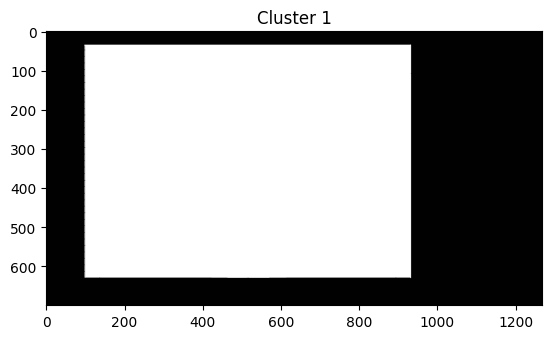

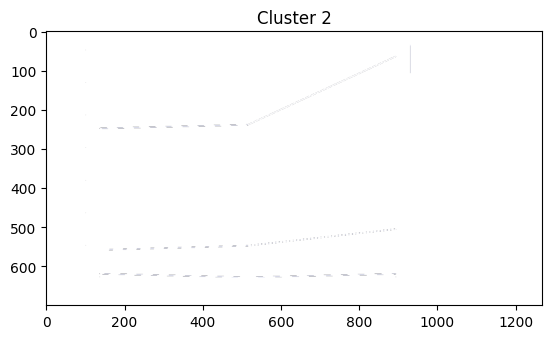

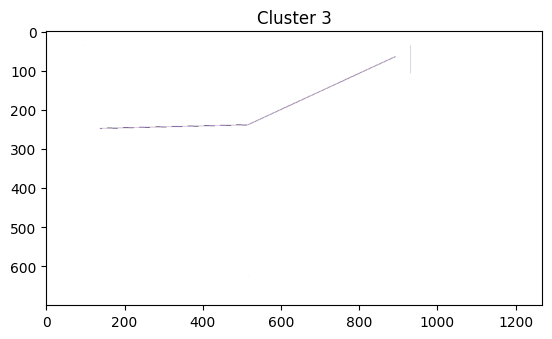

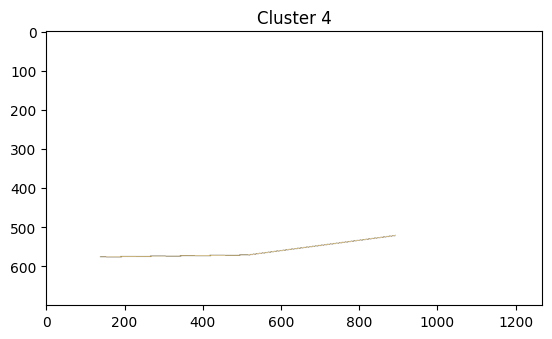

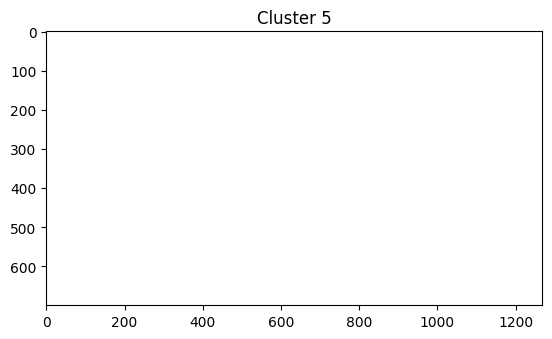

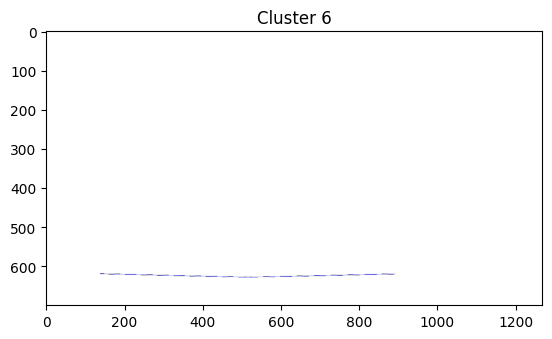

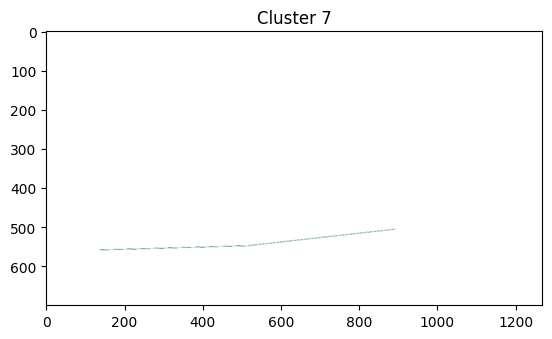

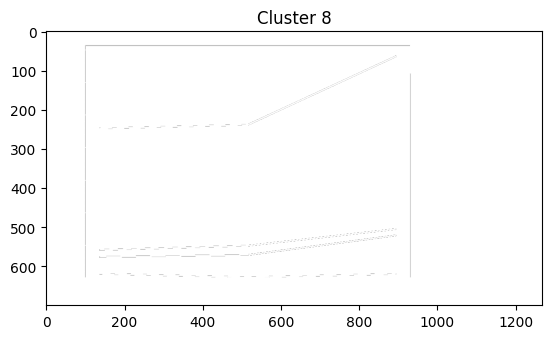

In [131]:
# Call the function with your image and mask paths
process_image('../plot_images/'+str(image_num)+'.png', boundingBox, 8)